# Second Project - Simplified catchment w/ stream

## Model Description 
This is a steady state, 3-layered box model with: recharge, a stream, ET, no-flow bedrock, topography, and a well.

#### Dimensions: 
- 50 by 50 (y, x)
- dx = dy = 1000 m
- dz_1 = variable; dz_2 = 5m; dz_3 = 40m 

#### Topography
- Land surface up to 125m above the datum on the left hand side
- sloping to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K_1 = K_3 = 8.5 m/day in x and y and z
- K_2 = 8.5 m/day in x and y and z for [1, :, 20:] 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001  

#### Boundary Conditions: 
 - Left boundary is no flow
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 4E-5 m/d [:, :14]
 
#### Well: 
 - Pumping well
     - Located at (0, 21, 38)
     - Pumping at a rate of 1500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [2]:
## model directory
moddir="../../mf2005"

# Setup image filepath
img_path='../../images/hw11/'

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Hydrogeologic parameters
K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
Ss[:,:,:] = 1e-4
Sy = 0.1       #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 4e-5 # m/day

## Evapotranspiration
et_field = 1e-5 # m/day occurs across right half of domain
et_rip = 5e-4   # m/day occurs along riparian area

## Well
pumping = 0 #m3/day  #given
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1) #convert the x location to a column
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
print(well_loc)
#print(well_col)


## Boundary conditions
h_right = 70

(2, 20.0, 37.0)


C:\Users\moral\AppData\Local\Temp\ipykernel_17392\3666974756.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage


## 4. Setup and run MODFLOW for the three layer scenario 

In [3]:
#Initialize the model
proj = "ThreeLayer"
m3 = flopy.modflow.Modflow(proj, exe_name = moddir)

#Savefig object name
m3_fig = '3-lay'

## Make some changes to the parameters
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert
Kz[1,:, 20:] = 0.0001                 # Replace the Kz in the last 30 columns of the middle layer

Kh = np.zeros((nlay,nrow,ncol))     # the entire domain is set to Kh = 8.5 m/d
Kh[:,:,:] = K_horiz                 


## Discretization - dis ##
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas

## DEFINE CELL ACTIVITY (IBOUND) ##
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = 0          # left no-flow boundary
ibound[:,:,-1] = -1        #  right active boundary

# Setup for loop to make bedrock
for i in range(0,9): 
    if i <= 5:                              # top layer bedrock
        ibound[0, i, 0:5-i] = 0
        ibound[0, -1-i, 0:5-i] = 0
    elif 6 <= i <= 7:                       # mid layer bedrock
        for j in range(0,7):
            ibound[1, j, 0:7-j] = 0
            ibound[1, -1-j, 0:7-j] = 0
    else:                                   # bot layer bedrock
        for k in range(0,9):
            ibound[2, k, 0:9-k] = 0
            ibound[2, -1-k, 0:9-k] = 0


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

## RECHARGE ##
rech_zone = np.zeros((1, nrow,ncol))
rech_zone[:, :, 0:15] = rech_zone[:, :, 0:15] + recharge                # recharge occurs on first 15 columns
#rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)


## EVAPOTRANSPIRATION ##
et_zone = np.zeros((nrow,ncol))
et_zone[:, 25:] = et_zone[:, 25:] + et_field                # ET across right half of domain     
et_zone[21:28,:] = et_zone[21:28,:] + et_rip                # ET along riparian area
ext_depth = 1
#evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=et_zone, exdp=ext_depth, ipakcb=53)

## WELL ##
well_1 = [i for i in well_loc] + [pumping]
wel_spd = {0: [well_1]} #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)

## STREAM ##
# Stream characteristics
ntrib = 2
nseg = 3
slope = 0.001                       # slope of streambed (m/m)
rough = 0.04                        # roughness of streambed
width = 1.                          # x-sectional width of channel (m)
Flow_into_the_1st_reach = 0         # m^3/day
set_icalc = 1                       # 1 if the stage is to be calculated based on flow, otherwise specify below
const = 86400.0                     # multiplication constant for m3/day - see documentation for other units
stage = 0.5                         # meters

# Calculate the streambed conductance
k_strbott = 1.36*K_horiz            #river bottom hydraulic conductivity in f/d
sed_thick = 1                       #thickness of riverbed sediment

# Setup the reach locations and numbers
nreach = ncol                           #river extends length of domain
str_rows = 24*np.ones(nreach,           #integer array of row numbers for each reach
                      dtype=np.int32)    
str_cols = np.arange(0,nreach)          #integer array of col numbers for each reach

# Setup the inflows for the reaches
Q_return = 0 # return flow from the town
return_loc = 24
reach_flow = np.ones((nreach), dtype=np.int32) # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Q_return # inflow to seg2 = return from town
reach_flow[return_loc+1] = 1 # inflow to seg3 = sum of all previous segs

# Setup segment and reach numbers for each grid cell
segments = np.zeros((nreach))
reaches = np.zeros((nreach))
for s in range(nreach):
    if s <= 23:                     # 1st segment/reach numbers
        segments[s] = 1
        reaches[s] = s+1
    elif s == return_loc:           # 2nd segment/reach numbers
        segments[s] = 2
        reaches[s] = 1
    else:                           # 3rd segment/reach numbers
        segments[s] = 3
        reaches[s] = s-return_loc

# Setup river elevations and stages relative to surface elev. (ztop)
surf_elev = np.zeros((nreach))      #create array of zeros the length of the stream
for i in np.arange(nreach):
    surf_elev[i] = ztop[str_rows[i],str_cols[i]]
str_top = surf_elev - 1             # elevation of streambed top (1m below land surface)
str_bott = str_top - sed_thick      #elevation of streambed bottom
stage_elev = str_top + stage

istcb2 = 53                          #save outflows to cbb file

# Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for recahes, each reach requires 13 input values

for r in np.arange(nreach):
    str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r],
                     reach_flow[r], stage_elev[r], k_strbott, str_bott[r],
                     str_top[r], width, slope, rough] 
str_spd = {0:str_info}          # save the stream info in a stress period dictionary

# Setup segments dictionary
seg_info = np.zeros((10,nseg))
seg_info = [[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[1,2,0,0,0,0,0,0,0,0,1]]
str_segd = {0:seg_info}

# strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib,
#                                       ndiv=0,icalc=set_icalc, const=const, ipakcb=53,
#                                       istcb2=53, dtype=None, stress_period_data=str_spd,
#                                       segment_data=str_segd, extension='str')


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 15:49:44

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 15:49:44
 Elapsed run time:  0.086 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

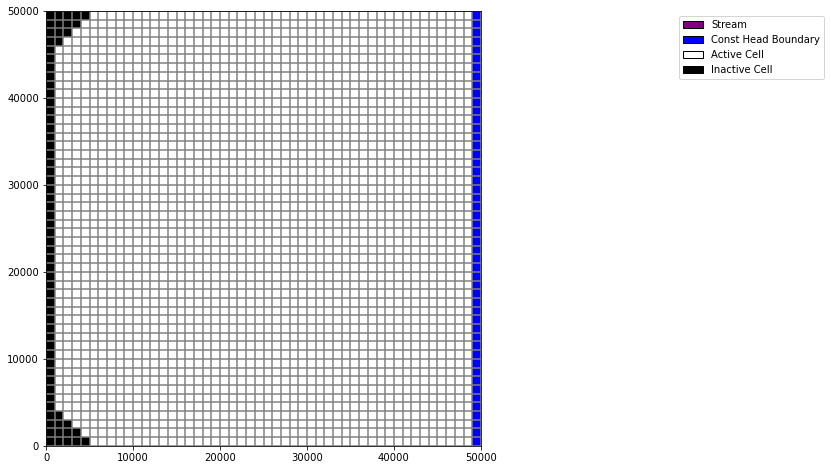

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m3)
ibound = mapview.plot_ibound()
#str_m = mapview.plot_bc("STR")
wel = mapview.plot_bc("WEL")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
linecollection = mapview.plot_grid()
plt.show(mapview)

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

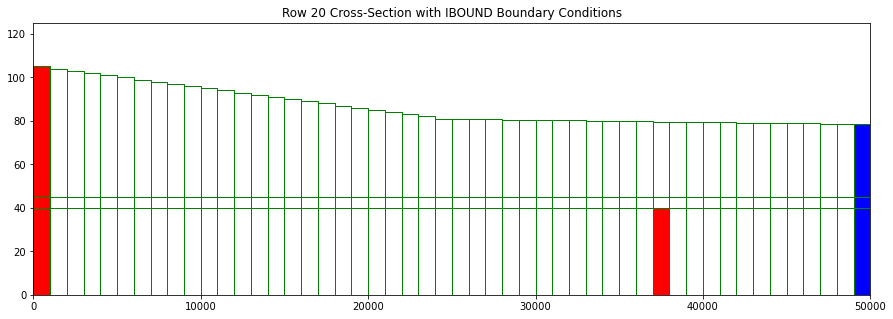

In [5]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': well_row}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 20 Cross-Section with IBOUND Boundary Conditions')

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [6]:
#Head - 3 layer model 
headobj = bf.HeadFile(proj+'.hds')    #reads the binary head file
times = headobj.get_times()                 #returns a list of timesteps
head_arr = headobj.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance - 3 layer
budgobj = bf.CellBudgetFile(proj+'.cbc')   #reads the cell budget file    
print(budgobj.get_unique_record_names())
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#rech_obj = budgobj.get_data(text='RECHARGE', totim=1.0) 
print(len(frf))
print(head_arr)

headobj = bf.HeadFile(proj+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[0]) #returns a numpy array of heads for specified time (last timestep)
head[head == -999.99] = np.nan     

budgobj = bf.CellBudgetFile(proj+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps

#Get the ET from the cell budget files
# et = budgobj.get_data(text='et', totim=1.0)
# #et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day]
# et_tot= np.sum(et_vals)
# print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
# recharge = budgobj.get_data(text='recharge', totim=1.0)
# #recharge_vals = np.squeeze(recharge)[0,:,:] #This is a matrix of the recharge fluxes [m3/day]
# rch_tot = np.sum(recharge_vals)
#print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux =', left_tot, " Right_flux=", right_tot)

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ']
1
[[[-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  ...
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]]

 [[-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  ...
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]]

 [[-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  [-999.99 -999.99 -999.99 ...   70.     70.     70.  ]
  ...
  [-999.99 -999.99 -999.99 ...   70.     70.     70

# 8. Plotting
### 8.1 Cross section plots

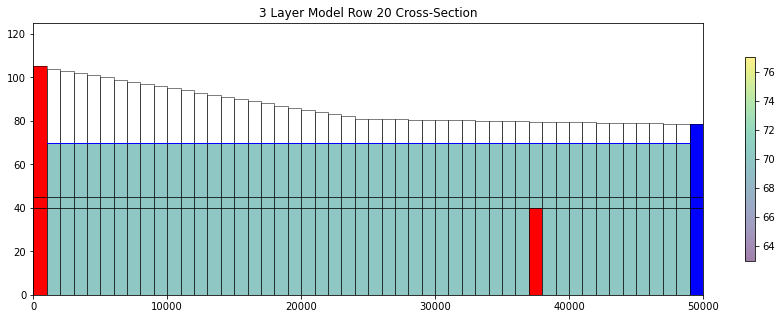

In [7]:
#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': well_row}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head_arr, masked_values=[-999.99], head=head_arr, alpha=0.5)
patches = xsect.plot_ibound(head=head_arr)
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 20 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head_arr[0,:,:], masked_values=[-999.99], color='blue', lw=1)
#plt.savefig(img_path+'valley-xsect_3lay')


# 9. Additional plots
### 9.1 Plot head transect

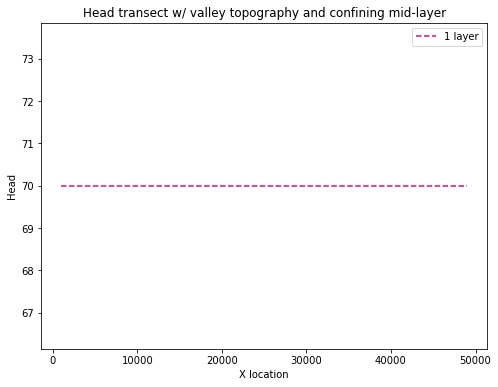

In [14]:
fig4 = plt.figure(figsize=(8,6)) 
ax = fig4.add_subplot(1, 1, 1)


x=np.arange(0,50000,1000) 
plt.plot(x,head[0,int(well_row),:], color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.title('Head transect w/ valley topography and confining mid-layer')
plt.xlabel('X location')
plt.ylabel('Head')
#fig4.text(.1, .001, "*increased k-value (0.01 m/day) \n color scheme from https://learnui.design/tools/data-color-picker.html")
plt.legend()
plt.savefig(img_path+'head-transects_ch3')
# plt.savefig('Head_Transect.png')

### 9.2 1 Layer Head Contours

C:\Users\moral\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\moral\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


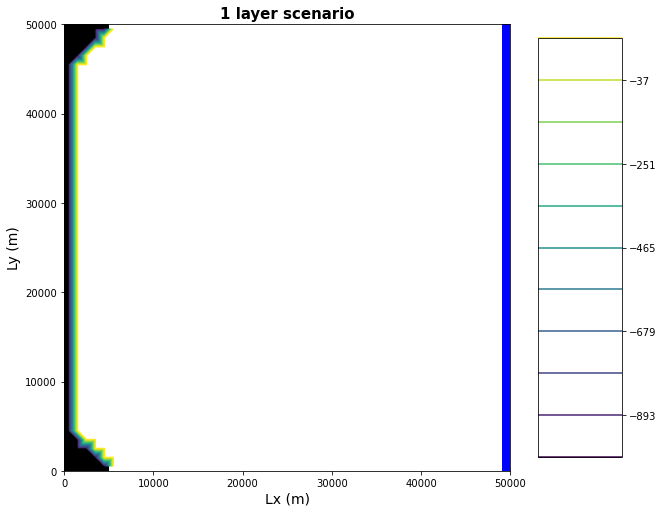

In [10]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head_arr[0].min(),head_arr[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head_arr, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head_arr) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

#plt.savefig(img_path+'contour-map_'+m1_fig)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

### 9.3 3 Layer head contours

In [11]:
# #f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
# fig3=plt.figure(figsize=(10,10))
# # print(fff1[0][0][40])
# # print(frf3[0][2][40])

# modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
# #grid = modelmap.plot_grid() #plot model grid
# qm = modelmap.plot_ibound()  
# contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
# head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
# flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

# #display parameters
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
# plt.colorbar(head_contours,aspect=5)

# plt.savefig(img_path+'contour-map_'+m3_fig)
# #plt.show(modelmap)
# #plt.savefig('WellScenario_vectors.png')   

In [12]:
headobj = bf.HeadFile(proj+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[0]) #returns a numpy array of heads for specified time (last timestep)
head[head == -999.99] = np.nan     

budgobj = bf.CellBudgetFile(proj+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps

#Get the ET from the cell budget files
# et = budgobj.get_data(text='et', totim=1.0)
# #et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day]
# et_tot= np.sum(et_vals)
# print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
# recharge = budgobj.get_data(text='recharge', totim=1.0)
# #recharge_vals = np.squeeze(recharge)[0,:,:] #This is a matrix of the recharge fluxes [m3/day]
# rch_tot = np.sum(recharge_vals)
#print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux =', left_tot, " Right_flux=", right_tot)

Left Flux = 0.0  Right_flux= 0.0


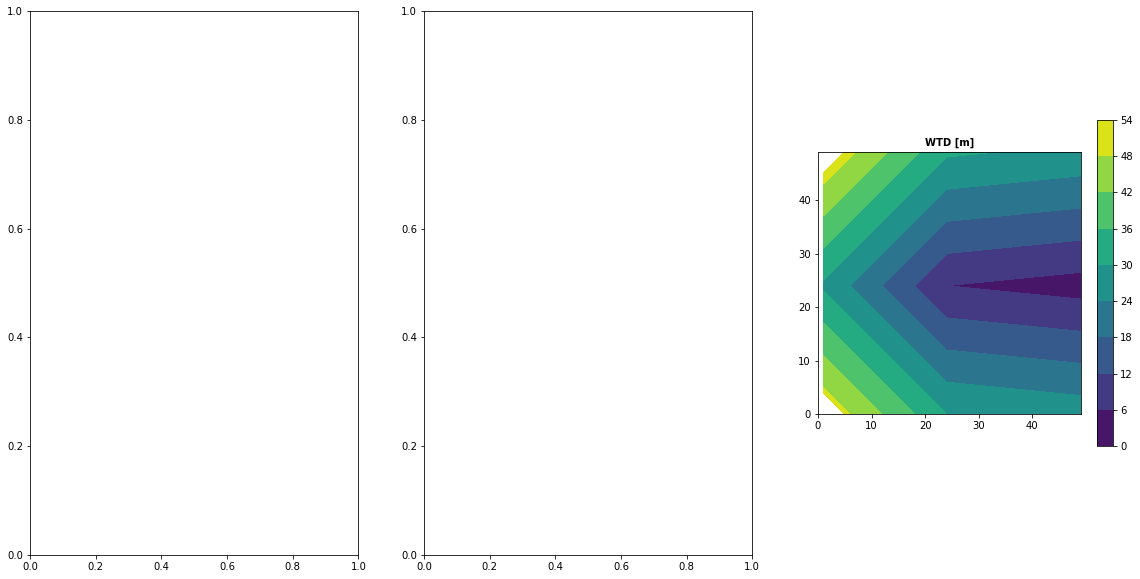

In [13]:
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(10) # calls within one line, fig(figure=(y,x))
fig.set_figwidth(20)

# #ET
# #ax1.set_xlabel('Lx (m)', fontsize=10)
# #ax1.set_ylabel('Ly (m)', fontsize=10)
# ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
# ax1.set_aspect('equal', 'box')
# etplot = ax1.contourf(np.flipud(et_vals))
# fig.colorbar(etplot, ax=ax1, shrink=0.6)


# #Recharge
# #ax2.set_xlabel('Lx (m)', fontsize=10)
# #ax2.set_ylabel('Ly (m)', fontsize=10)
# ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
# ax2.set_aspect('equal','box')
# rchplot = ax2.contourf(np.flipud(recharge_vals))
# fig.colorbar(rchplot, ax=ax2, shrink=0.6)


## WTD ##
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal','box')

wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.6)

plt.show()